# Plot data on a curvilinear grid using a rotated pole

In this example we show how to work with a curvilinear grid using a rotated pole (rotated grid), which is often used by regional models. In this case you have to look carefully at the dimensions, because the dimensions of the data variable seem at first sight to be defined on a regular grid, since the coordinate variables of the data variables are 1-dimensional.

E.g. for a variable tas:

    tas(time, rlat, rlon)

But if you look at the names of the dimensions of the data variable more precisely, they usually do not depend on lat and lon or latitude and longitude, but rather rlat and rlon.

    rlat(rlat)
    rlon(rlon)
 
With a little luck the variables lat and lon of the regular non-rotated grid are included in the file, if not, the variable rotated_pole with the attributes grid_north_pole_latitude and grid_north_pole_longitude must be included to transform the rotated to the non-rotated grid.

As an example of a curvilinear grid with rotated pole we use **CORDEX EUR-11** data. With the command line program `ncdump` we can take a look at the metadata of the file contents.

`ncdump -h rotated_curvilinear_data.nc`

```
netcdf rotated_curvilinear_data {
dimensions:
	time = UNLIMITED ; // (1 currently)
	bnds = 2 ;
	rlon = 424 ;
	rlat = 412 ;
variables:
	double time(time) ;
		time:standard_name = "time" ;
		time:long_name = "time" ;
		time:bounds = "time_bnds" ;
		time:units = "days since 1949-12-01 00:00:00" ;
		time:calendar = "standard" ;
		time:axis = "T" ;
	double time_bnds(time, bnds) ;
	double lon(rlat, rlon) ;
		lon:standard_name = "longitude" ;
		lon:long_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:_CoordinateAxisType = "Lon" ;
	double lat(rlat, rlon) ;
		lat:standard_name = "latitude" ;
		lat:long_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:_CoordinateAxisType = "Lat" ;
	double rlon(rlon) ;
		rlon:standard_name = "grid_longitude" ;
		rlon:long_name = "longitude in rotated pole grid" ;
		rlon:units = "degrees" ;
		rlon:axis = "X" ;
	double rlat(rlat) ;
		rlat:standard_name = "grid_latitude" ;
		rlat:long_name = "latitude in rotated pole grid" ;
		rlat:units = "degrees" ;
		rlat:axis = "Y" ;
	int rotated_pole ;
		rotated_pole:grid_mapping_name = "rotated_latitude_longitude" ;
		rotated_pole:grid_north_pole_latitude = 39.25 ;
		rotated_pole:grid_north_pole_longitude = -162. ;
	double height ;
		height:standard_name = "height" ;
		height:long_name = "height" ;
		height:units = "m" ;
		height:positive = "up" ;
		height:axis = "Z" ;
	float tas(time, rlat, rlon) ;
		tas:standard_name = "air_temperature" ;
		tas:long_name = "Near-Surface Air Temperature" ;
		tas:units = "K" ;
		tas:grid_mapping = "rotated_pole" ;
		tas:coordinates = "height lat lon" ;
		tas:_FillValue = 1.e+20f ;
		tas:missing_value = 1.e+20f ;
		tas:cell_methods = "time: mean" ;

// global attributes:
		:Conventions = "CF-1.4" ;
		:project_id = "CORDEX" ;
		:CORDEX_domain = "EUR-11" ;
}
```


### Import python modules

#### Used modules
    xarray:      read netCDF file
    numpy:       handle data arrays
    matplotlib:  create the plot
    cartopy:     use projection RotatedPole

In [1]:
import xarray as xr
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

### Allow to display the output of plotting commands in notebook

In [2]:
%matplotlib inline

### Function read_data

The function read_data opens the data file, read the variable data, and return relevant variables to the main function.

- open and decode a dataset from the netCDF file
- select variable tas, first time step
- select coordinate variables rlat and rlon of the rotated grid
- select rotated_pole variable to get the used pole coordinates

In [3]:
def read_data(file_name):
    """
    Read netcdf file and return variables: 
        rlat, rlon, var, px and py.
    """
    # read the dataset
    ds = xr.open_dataset(file_name)
    
    # retrieve the data of variable tas, coordinate variables rlat and rlon, and rotated pole
    var  = ds.tas[0,:,:]
    rlat = ds.rlat[:]
    rlon = ds.rlon[:]
    pole = ds.rotated_pole
    
    try:
        # retrieve attribute grid_north_pole_longitude
        if hasattr(pole,'grid_north_pole_longitude'):
            px = pole.attrs['grid_north_pole_longitude']
        
        # retrieve attribute grid_north_pole_latitude
        if hasattr(pole,'grid_north_pole_latitude'):
            py = pole.attrs['grid_north_pole_latitude']
    except:
        print('Unexpected error:', sys.exc_info()[0])
        raise
        
    return rlon, rlat, var, px, py

### Function main
Create the contour fill plot of variable tas. The cartopy projection RotatedPole is used to draw the data above the original region of Europe. Save the plot output to a PNG file.

In [4]:
def main():
    """
    Draw variable tas on map using the RotatedPole projection.
    The coordinate variables rlat and rlon are required.
    """
    dir_name = 'data/'
    file_name = 'rotated_curvilinear_data.nc'
    fname = os.path.join(dir_name,file_name)
    
    # read file content and return relevant variables
    rlon, rlat, var, pole_lon, pole_lat = read_data(fname)
    
    # initialize plot
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-46, 70, 20, 75], crs=ccrs.PlateCarree())
    
    # set fill colors for ocean and land areas
    ax.add_feature(cartopy.feature.OCEAN, color='white', zorder=0)
    ax.add_feature(cartopy.feature.LAND, color='lightgray',zorder=0, 
                   linewidth=0.5, edgecolor='black')
    
    # add gridlines
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', xlocs=range(-180,180,15), ylocs=range(-90,90,15))
    
    # add coastlines
    ax.coastlines(resolution='50m', linewidth=0.3, color='black')
    
    # add title
    ax.set_title('Python: rotated curvilinear grid', fontsize=10, fontweight='bold')

    # set projection
    crs = ccrs.RotatedPole(pole_longitude=pole_lon, pole_latitude=pole_lat)
    
    # contour fill plot
    ax.contourf(rlon, rlat, var, levels=15, cmap='RdYlBu_r', transform=crs)

    # save the plot output to PNG file (and display it in notebook if '%matplotlib inline' is set)
    plt.savefig('Py_rotated_curvilinear_grid_1.png', bbox_inches='tight', dpi=200)

### Run main

And here we go ...

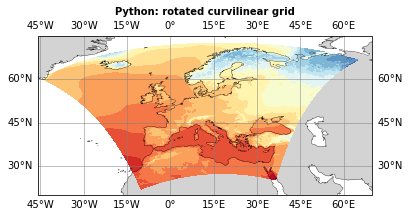

In [5]:
if __name__ == '__main__':
    main()